In [1]:
import fitz
import numpy as np
import pandas as pd
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt
import csv
from matplotlib.widgets import Button

In [2]:
# Read the PDF map and define the pixel coordinate system
def load_map_as_image(pdf_path, dpi = 300):

    doc = fitz.open(pdf_path)
    page = doc[0]

    # Transfer into bitmap
    pix = page.get_pixmap(dpi=dpi)
    img_pil = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    img_arr = np.array(img_pil)

    H, W = img_arr.shape[0], img_arr.shape[1]
    print(f"Map image size: width={W} px, height={H} px")
    print("Pixel coordinate system: x ∈ [0, W), y ∈ [0, H) with origin at top-left.")
    return img_pil, img_arr, W, H

img_pil, img_arr, W, H = load_map_as_image("campus_map.pdf", dpi=300)

Map image size: width=2839 px, height=4746 px
Pixel coordinate system: x ∈ [0, W), y ∈ [0, H) with origin at top-left.


# Emergency Call Box Coordinates

## Exisiting Call Boxes

Detected 24 existing call boxes.


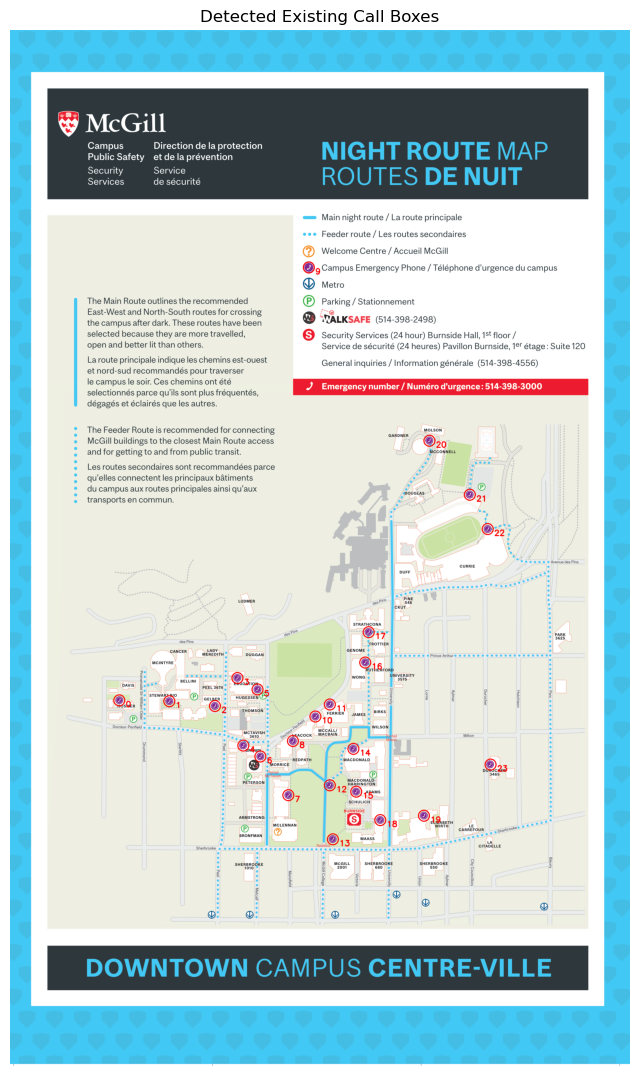

In [3]:
# Detect call box icons by color thresholding and return centroid coordinates from filtered contours
def detect_existing_callboxes(img_arr):
    # Convert RGB to BGR to HSV
    img_cv = cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

    # Purple range for callbox icons
    lower_purple = np.array([120, 40, 40])
    upper_purple = np.array([160, 255, 255])
    mask = cv2.inRange(hsv, lower_purple, upper_purple)

    # Clean noise
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    coords = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Bounding box size of typical callbox icon
        if 15 < w < 60 and 15 < h < 60:
            cx = x + w/2
            cy = y + h/2
            coords.append((round(cx), round(cy)))

    coords = sorted(coords)

    print(f"Detected {len(coords)} existing call boxes.")
    return coords

existing_boxes = detect_existing_callboxes(img_arr)

# Visualize
img = cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)
img_vis = img.copy()

for i, (x, y) in enumerate(existing_boxes):
    cv2.circle(img_vis, (x, y), 25, (0, 0, 255), 4)
    cv2.putText(img_vis, str(i), (x + 30, y + 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

# Display the results
plt.figure(figsize=(8, 14))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Existing Call Boxes")
plt.show()

In [4]:
# Remove the false detection (legend icon) at index 9 and re-sort the coordinates
removed = existing_boxes.pop(9)
existing_boxes = sorted(existing_boxes)

existing_boxes = pd.DataFrame({
    "supply_id": range(0, len(existing_boxes)),
    "x": [p[0] for p in existing_boxes],
    "y": [p[1] for p in existing_boxes],
})
existing_boxes.head()

,supply_id,x,y
0,0,500,3072
1,1,729,3076
2,2,938,3098
3,3,1041,2970
4,4,1068,3279


## Candidate Call Boxes

In [6]:
'''
We assume areas near campus buildings have better conditions to install phone call boxes and have higher pedestrian traffic, 
which may increase emergency call likelihood. 
Thus, we trace building outlines on the map and randomly generate 100 candidate points along these boundaries.
'''
# Interactively trace building outlines on the map (click vertices, press Enter to close polygons and save all vertices to CSV)
all_polygons = []
current_polygon = []

# Mouse callback
def click_event(event, x, y, flags, param):
    global current_polygon, img_display

    if event == cv2.EVENT_LBUTTONDOWN:
        current_polygon.append((x, y))
        # Draw point
        cv2.circle(img_display, (x,y), 4, (0,0,255), -1)
        cv2.imshow("Map - Click Vertices of Building Outline", img_display)

img_display = img.copy()
H, W = img_display.shape[:2]
cv2.namedWindow("Map - Click Vertices of Building Outline", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Map - Click Vertices of Building Outline", W, H)
cv2.setMouseCallback("Map - Click Vertices of Building Outline", click_event)

print("Instructions:")
print("Left click: add a point")
print("ENTER: finish current building polygon")
print("S: save all polygons to CSV")
print("Q: quit without saving\n")

while True:
    cv2.imshow("Map - Click Vertices of Building Outline", img_display)
    key = cv2.waitKey(1) & 0xFF

    # ENTER means finalize polygon
    if key == 13:  # Enter key
        if len(current_polygon) > 2:
            all_polygons.append(current_polygon)
        else:
            print("Polygon ignored (too few points).\n")

        current_polygon = []

    # S means save to CSV
    elif key == ord('s'):
        with open("building_outline_vertices.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["building_id", "x", "y"])
            for i, poly in enumerate(all_polygons):
                for (x, y) in poly:
                    writer.writerow([i, x, y])
        print("Saved to building_outline_vertices.csv")
        break

    # Q → quit without saving
    elif key == ord('q'):
        print("Quit without saving.")
        break

cv2.destroyAllWindows()

Instructions:
Left click: add a point
ENTER: finish current building polygon
S: save all polygons to CSV
Q: quit without saving

Saved to building_outline_vertices.csv


In [7]:
# Generate random candidate points along building polygon boundaries
df = pd.read_csv("building_outline_vertices.csv")

# Group by building_id
polygons = []
for bid, group in df.groupby("building_id"):
    pts = group[["x","y"]].values.tolist()
    polygons.append(pts)

# === Step 1: build edge list ===
edges = []
for poly in polygons:
    for i in range(len(poly)):
        x1, y1 = poly[i]
        x2, y2 = poly[(i+1)%len(poly)]  # Loop back
        length = np.hypot(x2-x1, y2-y1)
        edges.append((x1, y1, x2, y2, length))

# Total length
lengths = np.array([e[4] for e in edges])
total_length = lengths.sum()
probs = lengths / total_length   # Probability of selecting each edge

print("Total edges:", len(edges))
print("Total boundary length:", total_length)

# === Step 2: randomly pick 100 edges weighted by length ===
N = 100
chosen_indices = np.random.choice(len(edges), size=N, p=probs)

# === Step 3: generate random points along chosen edges ===
random_pts = []
for idx in chosen_indices:
    x1, y1, x2, y2, d = edges[idx]
    t = np.random.rand()  # Random ratio along the edge
    x = x1 + t*(x2 - x1)
    y = y1 + t*(y2 - y1)
    random_pts.append((round(x), round(y)))

# === Step 4: assign supply IDs ===
candidate_boxes = pd.DataFrame({
    "supply_id": np.arange(23, 23+N),
    "x": [p[0] for p in random_pts],
    "y": [p[1] for p in random_pts],
})

Total edges: 441
Total boundary length: 25043.25700916567


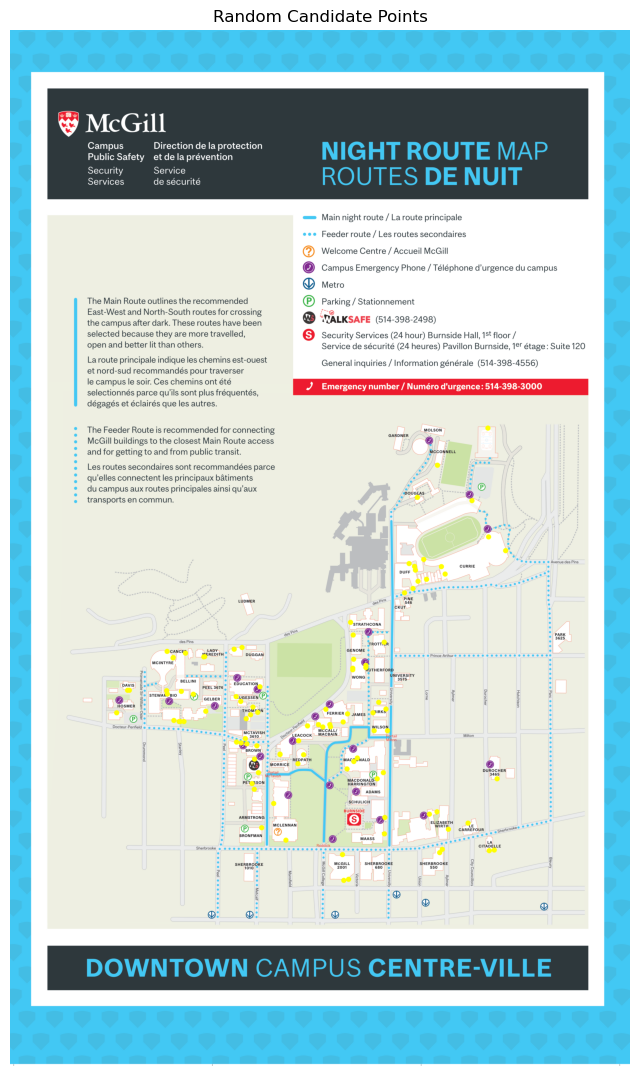

In [8]:
# Visualize the generated candidate points to verify they lie on building boundaries
vis = img.copy()

for x, y in candidate_boxes[['x','y']].values:
    cv2.circle(vis, (x, y), 12, (0,255,255), -1)

plt.figure(figsize=(8,14))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Random Candidate Points")
plt.show()

In [9]:
# Merge exisiting and candidate boxes
all_boxes = pd.concat([existing_boxes, candidate_boxes], ignore_index=True)

# Sort by supply_id to maintain order
all_boxes = all_boxes.sort_values("supply_id").reset_index(drop=True)

# Save the file
all_boxes.to_csv("exisiting_and_candidate_callbox_coords.csv", index=False)

print("Saved to exisiting_and_candidate_callbox_coords.csv")
print("Total points:", len(all_boxes))

Saved to exisiting_and_candidate_callbox_coords.csv
Total points: 123


# Emergency Phone Demand Point Coordinates

## Trace Solid and Dotted Blue Lines

In [13]:
'''
We place potential emergency phone demand points along the main night routes and feeder routes on the map, 
assuming indoor demand can be approximated by the nearest point on these routes.

We sample one demand point every 50 meters along these routes. 
To do this, we use the existing call boxes at indices 15 and 16 as reference points 
and compute a meters-per-pixel scale from their pixel distance and known real-world distance.

We also assume demand is higher on the main night routes (solid blue lines) than on feeder routes (dotted blue lines), 
so we assign a higher weight to points on the main routes.
'''
# Interactively trace solid blue line polylines on the map (click vertices, press Enter to finish each line and save all vertices to CSV)
img_sline = img.copy()

solid_lines = []
current_line = []

# Mouse callback
def click_event(event, x, y, flags, param):
    global current_line
    if event == cv2.EVENT_LBUTTONDOWN:
        current_line.append((x, y))
        # Draw visible dot
        cv2.circle(img_sline, (x, y), 4, (0, 0, 255), -1)
        cv2.imshow("Map - Click Vertices of Solid Blue Lines", img_sline)

cv2.namedWindow("Map - Click Vertices of Solid Blue Lines", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Map - Click Vertices of Solid Blue Lines", W, H)
cv2.setMouseCallback("Map - Click Vertices of Solid Blue Lines", click_event)

print("Instructions:")
print("Left click: add a point")
print("ENTER: finish current solid line")
print("S: save all solid lines to CSV")
print("Q: quit without saving\n")

while True:
    cv2.imshow("Map - Click Vertices of Solid Blue Lines", img_sline)
    key = cv2.waitKey(20) & 0xFF

    # ENTER means finalize current line
    if key == 13:  # ENTER
        if len(current_line) >= 2:
            solid_lines.append(current_line)
        else:
            print("Ignored short line.")
        current_line = []

    # S means save to CSV
    elif key == ord('s'):
        rows = []
        for line_id, line in enumerate(solid_lines):
            for order, (x, y) in enumerate(line):
                rows.append([line_id, order, x, y])

        df = pd.DataFrame(rows, columns=["line_id", "order", "x", "y"])
        df.to_csv("solid_line_vertices.csv", index=False)
        print("Saved to solid_line_vertices.csv")
        break

    # Q → quit without saving
    elif key == ord('q'):
        print("Quit without saving.")
        break

cv2.destroyAllWindows()

Instructions:
Left click: add a point
ENTER: finish current solid line
S: save all solid lines to CSV
Q: quit without saving

Saved to solid_line_vertices.csv


In [14]:
# Interactively trace dotted blue line polylines on the map
img_dline = img.copy()

dotted_lines = []
current_line = []

# Mouse callback
def click_event(event, x, y, flags, param):
    global current_line
    if event == cv2.EVENT_LBUTTONDOWN:
        current_line.append((x, y))
        # Draw visible dot
        cv2.circle(img_dline, (x, y), 4, (255, 0, 0), -1) 
        cv2.imshow("Map - Click Vertices of Dotted Blue Lines", img_dline)

cv2.namedWindow("Map - Click Vertices of Dotted Blue Lines", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Map - Click Vertices of Dotted Blue Lines", W, H)
cv2.setMouseCallback("Map - Click Vertices of Dotted Blue Lines", click_event)

print("Instructions:")
print("Left click: add a point")
print("ENTER: finish current dotted line")
print("S: save all dotted lines to CSV")
print("Q: quit without saving\n")

while True:
    cv2.imshow("Map - Click Vertices of Dotted Blue Lines", img_dline)
    key = cv2.waitKey(20) & 0xFF

    # ENTER means finalize current line
    if key == 13:  # ENTER
        if len(current_line) >= 2:
            dotted_lines.append(current_line)
        else:
            print("Ignored short line.")
        current_line = []

    # S means save to CSV
    elif key == ord('s'):
        rows = []
        for line_id, line in enumerate(dotted_lines):
            for order, (x, y) in enumerate(line):
                rows.append([line_id, order, x, y])

        df = pd.DataFrame(rows, columns=["line_id", "order", "x", "y"])
        df.to_csv("dotted_line_vertices.csv", index=False)
        print("Saved to dotted_line_vertices.csv")
        break

    # Q → quit without saving
    elif key == ord('q'):
        print("Quit without saving.")
        break

cv2.destroyAllWindows()

Instructions:
Left click: add a point
ENTER: finish current dotted line
S: save all dotted lines to CSV
Q: quit without saving

Saved to dotted_line_vertices.csv


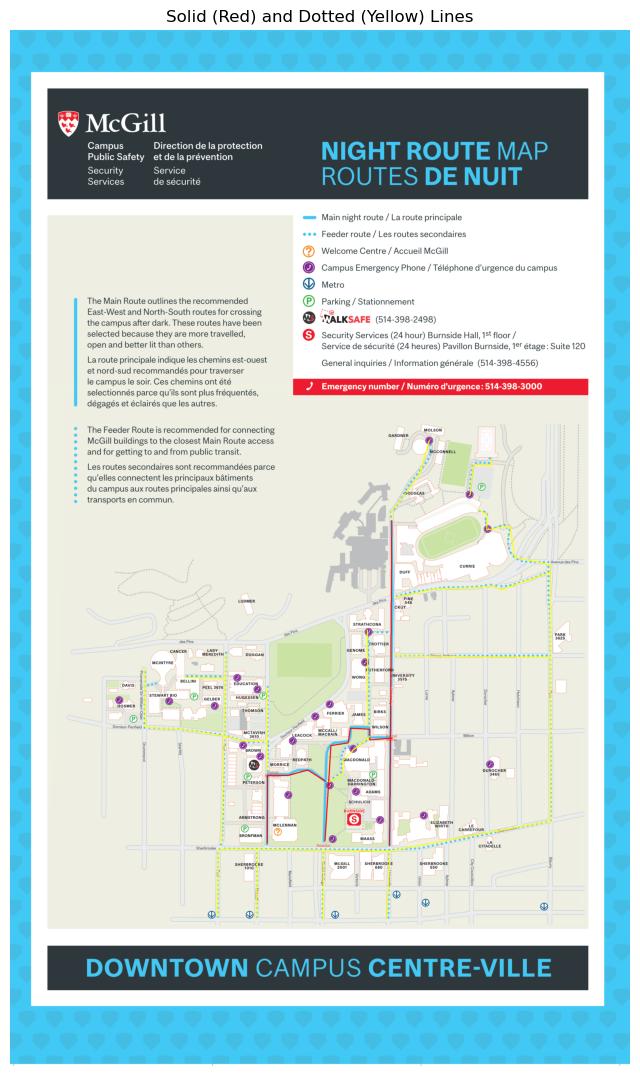

In [15]:
# Visualize to check
img_line = img.copy()

# Load solid and dotted lines
df_solid = pd.read_csv("solid_line_vertices.csv")
df_dotted = pd.read_csv("dotted_line_vertices.csv")

# Draw solid lines to be red
for line_id, group in df_solid.groupby("line_id"):
    pts = group[["x","y"]].values.astype(int)
    for i in range(len(pts)-1):
        x1, y1 = pts[i]
        x2, y2 = pts[i+1]
        cv2.line(img_line, (x1, y1), (x2, y2), (0,0,255), 4)   # Red

# Draw dotted lines to be yellow
for line_id, group in df_dotted.groupby("line_id"):
    pts = group[["x","y"]].values.astype(int)
    for i in range(len(pts)-1):
        x1, y1 = pts[i]
        x2, y2 = pts[i+1]
        cv2.line(img_line, (x1, y1), (x2, y2), (0,255,255), 4)   # Yellow

# Show result
plt.figure(figsize=(8,14))
plt.imshow(cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB))
plt.title("Solid (Red) and Dotted (Yellow) Lines")
plt.axis("off")
plt.show()

## Generate Demand Points

In [16]:
# Compute the meters-per-pixel scale using two reference points with a known real-world distance
def compute_scale_m_per_pixel(p1, p2, real_distance_m):
    x1, y1 = p1
    x2, y2 = p2
    d_pixels = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    scale = real_distance_m / d_pixels
    
    print(f"Pixel distance between p1 and p2: {d_pixels:.2f} pixels")
    print(f"Scale: 1 pixel ≈ {scale:.4f} meters")
    return scale

p1 = tuple(existing_boxes.iloc[15][["x", "y"]])
p2 = tuple(existing_boxes.iloc[16][["x", "y"]])
scale_m_per_pixel = compute_scale_m_per_pixel(p1, p2, 70.0)

Pixel distance between p1 and p2: 139.92 pixels
Scale: 1 pixel ≈ 0.5003 meters


In [18]:
# Generate evenly spaced demand points along solid/dotted polylines using the meters-to-pixels scale
scale_m_per_pixel = 0.5  
interval_m = 50     # Select one demand point every 50 meters
interval_px = interval_m / scale_m_per_pixel

# Convert a line-vertex DataFrame into a list of ordered polylines (paths)
def df_to_paths(df):
    paths = []
    for line_id, g in df.groupby("line_id"):
        g_sorted = g.sort_values("order")
        pts = g_sorted[["x", "y"]].values.tolist()
        paths.append(pts)
    return paths
    
# Interpolate equally spaced points along a single segment at a fixed interval
def interpolate_segment(p1, p2, interval_px):
    (x1, y1), (x2, y2) = p1, p2
    dist = np.hypot(x2 - x1, y2 - y1)

    if dist == 0:
        return []

    num_points = int(dist // interval_px)
    pts = []

    for k in range(1, num_points + 1):
        t = (k * interval_px) / dist
        x = x1 + (x2 - x1) * t
        y = y1 + (y2 - y1) * t
        pts.append((round(x), round(y)))
    return pts
  
# Generate demand points for all polylines
def process_paths(paths, weight):
    all_pts = []
    for path in paths:
        for i in range(len(path) - 1):
            p1, p2 = path[i], path[i+1]
            interp = interpolate_segment(p1, p2, interval_px)
            for x, y in interp:
                all_pts.append([x, y, weight])
    return all_pts

solid_paths = df_to_paths(df_solid)
dotted_paths = df_to_paths(df_dotted)

solid_points = process_paths(solid_paths, weight=1.5)
dotted_points = process_paths(dotted_paths, weight=1)

all_points = solid_points + dotted_points
df_all = pd.DataFrame(all_points, columns=["x", "y", "weight"])
df_all.insert(0, "ID", range(len(df_all)))

# Save files
df_all.to_csv("demand_point_coords.csv", index=False)
print("Saved to demand_point_coords.csv")
print("Total demand points:", len(df_all))

Saved to demand_point_coords.csv
Total demand points: 98


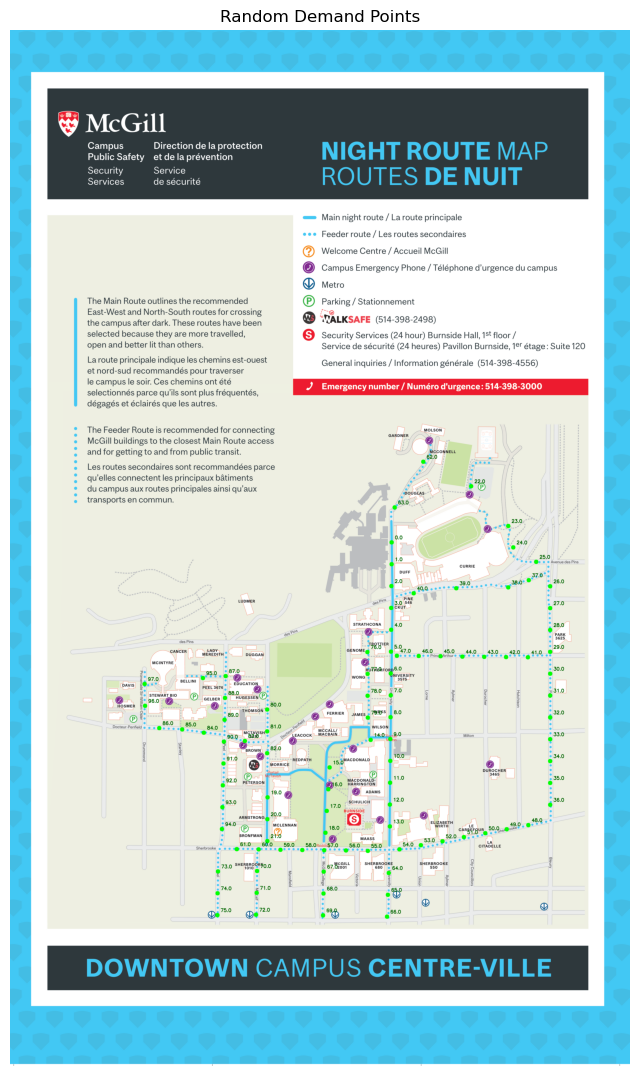

In [19]:
# Visualize to check
img_demand = img.copy()
for i, row in df_all.iterrows():
    x, y = int(row["x"]), int(row["y"])
    cv2.circle(img_demand, (x, y), 10, (0, 255, 0), -1)
    cv2.putText(img_demand, str(row["ID"]), (x+15, y-15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 100, 0), 2)

plt.figure(figsize=(8, 14))
plt.imshow(cv2.cvtColor(img_demand, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Random Demand Points")
plt.show()